# Introduction to PopTorch - running a simple model

This tutorial covers the basics of model making in PyTorch,
using `torch.nn.Module`, and the specific methods to
convert a PyTorch model to a PopTorch model so that it can
be run on a Graphcore IPU.

Requirements:
   - an installed Poplar SDK. See the Getting Started guide
     for your IPU hardware for details of how to install
     the SDK;
   - Python packages with `pip install -r requirements.txt`

# Table of Contents
- [What is PopTorch?](#What-is-PopTorch?)
- [Getting started: training a model on the IPU](#Getting-started:-training-a-model-on-the-IPU)
    - [Import the packages](#Import-the-packages)
    - [Load the data](#Load-the-data)
        - [PopTorch DataLoader](#PopTorch-DataLoader)
    - [Build the model](#Build-the-model)
    - [Prepare training for IPUs](#Prepare-training-for-IPUs)
    - [Train the model](#Train-the-model)
      - [Training loop](#Training-loop)
      - [Use the same IPU for training and inference](#Use-the-same-IPU-for-training-and-inference)
      - [Save the trained model](#Save-the-trained-model)
    - [Evaluate the model](#Evaluate-the-model)
- [Doing more with `poptorch.Options`](#Doing-more-with-poptorch.Options)
    - [`deviceIterations`](#deviceIterations)
    - [`replicationFactor`](#replicationFactor)
    - [`randomSeed`](#randomSeed)
    - [`useIpuModel`](#useIpuModel)
    - [How to set the options](#How-to-set-the-options)
- [Going further](#Going-further)

## What is PopTorch?
PopTorch is a set of extensions for PyTorch to enable
PyTorch models to run on Graphcore's IPU hardware.

PopTorch supports both inference and training. To run a
model on the IPU you wrap your existing PyTorch model in
either a PopTorch inference wrapper or a PopTorch training
wrapper. You can provide further annotations to partition
the model across multiple IPUs.

You can wrap individual layers in an IPU helper to
designate which IPU they should go on. Using your
annotations, PopTorch will use [PopART]
(https://docs.graphcore.ai/projects/popart-user-guide)
to parallelise the model over the given number of IPUs.
Additional parallelism can be expressed via a replication
factor which enables you to data-parallelise the model over
more IPUs.

Under the hood PopTorch uses [TorchScript](https://pytorch.org/docs/stable/jit.html),
an intermediate representation (IR) of a PyTorch model,
using the `torch.jit.# trace` API. That means it inherits
the constraints of that API. These include:

- Inputs must be Torch tensors or tuples/lists containing Torch tensors;
- None can be used as a default value for a parameter but cannot be
expliticly passed as an input value;
- Hooks and `.grad` cannot be used to inspect weights and gradients;
- `torch.jit.trace` cannot handle control flow or shape
variations within the model. That is, the inputs passed at
run-time cannot vary the control flow of the model or the
shapes/sizes of results.

To learn more about TorchScript and JIT, you can go through
this [tutorial](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html).

PopTorch has been designed to require few manual
alterations to your models in order to run them on IPU.
However, it does have some differences from native PyTorch
execution. Also, not all PyTorch operations have been
implemented by the backend yet. You can find the list of
supported operations [here](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest supported_ops.html).

![Software stack](static/stack.jpg)

# Getting started: training a model on the IPU
We will do the following steps in order:
1. Load the Fashion-MNIST dataset using `torchvision.datasets` and `poptorch.
DataLoader`
2. Define a deep CNN  and a loss function using the `torch` API
3. Train the model on an IPU using `poptorch.trainingModel`
4. Evaluate the model on the IPU

### Import the packages
PopTorch is a separate package from PyTorch, and available
in Graphcore's Poplar SDK. Both must thus be imported:

In [1]:
import torch
import poptorch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

Under the hood, PopTorch uses Graphcore's high-performance
machine learning framework PopART. It is therefore necessary
to enable PopART and Poplar in your environment.

>**NOTE**:
>If you forget PopART, you will encounter the error
>`ImportError: libpopart.so: cannot open shared object file: No such file or
>directory` when importing `poptorch`.
>If the error message says something like `libpopart_compiler.so: undefined
>symbol: _ZN6popart7Session3runERNS_7IStepIOE`, it most likely means the
>versions of PopART and PopTorch do not match, for example by enabling PopART
>with a previous SDK release's `enable.sh` script. Make sure to not mix SDK's
>artifacts.

### Load the data
We will use the Fashion-MNIST dataset made available by the package
`torchivsion`. This dataset, from [Zalando](https://github.com/zalandoresearch/fashion-mnist),
can be used as a more challenging replacement to the well-known MNIST dataset.

The dataset consists of 28x28 grayscale images and labels of range \[0, 9]
from 10 classes: T-shirt, trouser, pullover, dress, coat, sandal, shirt,
sneaker, bag and ankle boot.

In order for the images to be usable by PyTorch, we have to convert them to
`torch.Tensor` objects. Also, data normalisation improves overall
performance. We will apply both operations, conversion and normalisation, to
the datasets using `torchvision.transforms` and feed these ops to
`torchvision.datasets`:

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST("./datasets/", transform=transform, download=True, train=True)
test_dataset = torchvision.datasets.FashionMNIST("./datasets/", transform=transform, download=True, train=False)
classes = ("T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")


/home/adamw/adam_env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


With the following method, we can visualise a sample of these images and
their associated labels:

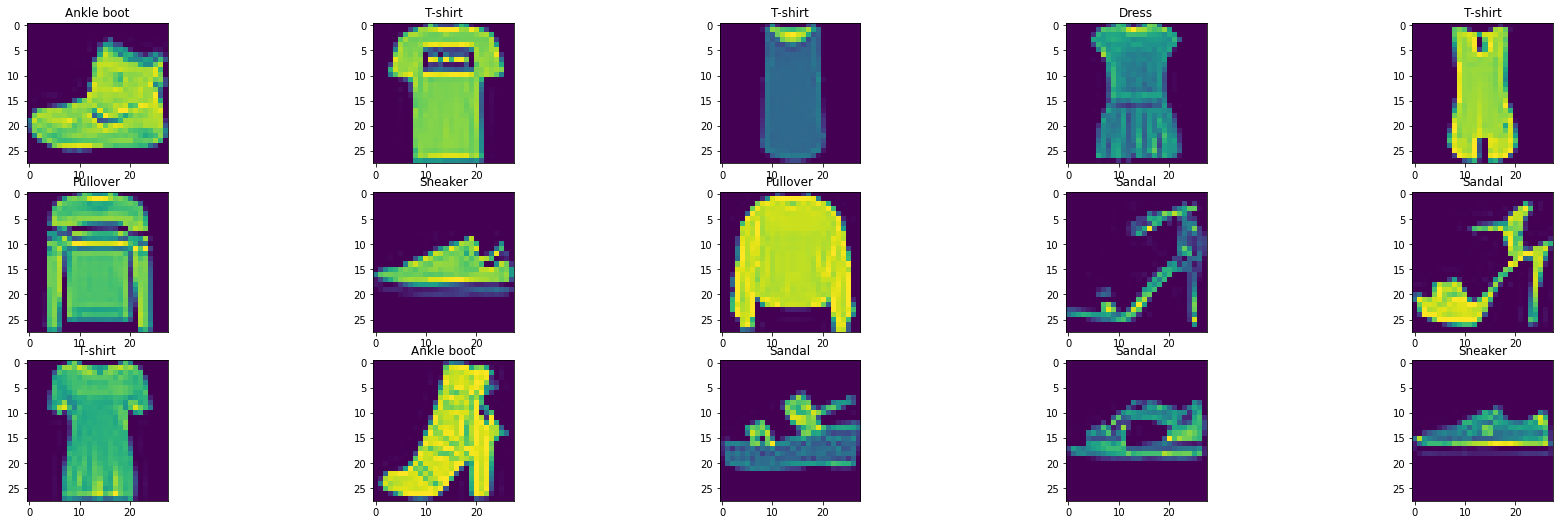

In [3]:
plt.figure(figsize=(30, 15))
for i, (image, label) in enumerate(train_dataset):
    if i == 15:
        break
    image = (image / 2 + .5).numpy()  # reverse transformation
    ax = plt.subplot(5, 5, i + 1)
    ax.set_title(classes[label])
    plt.imshow(image[0])

![png](static/from_0_to_1_10_0.png)

##### PopTorch DataLoader
We can feed batches of data into a PyTorch model by simply passing the input
tensors. However, this is unlikely to be the most efficient way and can
result in data loading being a bottleneck to the model, slowing down the
training process. In order to make data loading easier and more efficient,
there's the [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html)
class, which is an iterable over a dataset and which can handle parallel data
loading, a sampling strategy, shuffling, etc.

PopTorch offers an extension of this class with its [`poptorch.DataLoader`]
(https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/batching.html#poptorch-dataloader)
class, specialised for the way the underlying PopART framework handles
batching of data. We will use this class later in the tutorial, as soon as we
have a model ready for training.

### Build the model
We will build a simple CNN model for a classification task. To do so, we can
simply use PyTorch's API, including `torch.nn.Module`. The difference from
what we're used to with pure PyTorch is the _loss computation_, which has to
be part of the `forward` function. This is to ensure the loss is computed on
the IPU and not on the CPU, and to give us as much flexibility as possible
when designing more complex loss functions.

In [4]:

class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 12, 5)
        self.norm = nn.GroupNorm(3, 12)
        self.fc1 = nn.Linear(972, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)
        self.log_softmax = nn.LogSoftmax(dim=0)
        self.loss = nn.NLLLoss()

    def forward(self, x, labels=None):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.norm(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.log_softmax(self.fc2(x))
        # The model is responsible for the calculation
        # of the loss when using an IPU. We do it this way:
        if self.training:
            return x, self.loss(x, labels)
        return x

model = ClassificationModel()


**NOTE**: `self.training` is inherited from `torch.nn.Module` which
initialises its value to `True`. Use `model.eval()` to set it to `False` and
`model.train()` to switch it back to `True`.

### Prepare training for IPUs
The compilation and execution on the IPU can be controlled using `poptorch.
Options`. These options are used by PopTorch's wrappers such as `poptorch.
DataLoader` and `poptorch.trainingModel`.

In [5]:
opts = poptorch.Options()

train_dataloader = poptorch.DataLoader(opts, train_dataset, batch_size=16, shuffle=True, num_workers=20)


### Train the model
We will need another component in order to train our model: an optimiser.
Its role is to apply the computed gradients to the model's weights to optimize
(usually, minimize) the loss function using a specific algorithm. PopTorch
currently provides classes which inherit from multiple native PyTorch optimisation
functions: SGD, Adam, AdamW, LAMB and RMSprop. These optimisers provide several
advantages over native PyTorch versions. They embed constant attributes to save
performance and memory, and allow you to specify additional parameters such as
loss/velocity scaling.

We will use SGD (https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/reference.html#poptorch.optim.SGD)
as it's a very popular algorithm and is appropriate for this classification task.

In [6]:
optimizer = poptorch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


[03:32:29.183] [poptorch::python] [warning] Default SGD implementation has changed to the more stable but more memory intensive separate variant. To suppress set use_combined_accum=False with poptorch.optim.SGD; to restore old behaviour, set use_combined_accum=True


We now introduce the `poptorch.trainingModel` wrapper, which will handle the
training. It takes an instance of a `torch.nn.Module`, such as our custom
model, an instance of `poptorch.Options` which we have instantiated
previously, and an optimizer. This wrapper will trigger the compilation of
our model, using TorchScript, and manage its translation to a program the
IPU can run. Let's use it.

In [7]:
poptorch_model = poptorch.trainingModel(model, options=opts, optimizer=optimizer)


#### Training loop
Looping through the training data, running the forward and backward passes,
and updating the weights constitute the process we refer to as the "training loop".
Graphcore's Poplar system uses several optimisations to accelerate the
training loop. Central to this is the desire to minimise interactions between
the device (the IPU) and the host (the CPU), allowing the training loop to
run on the device independently from the host. To achieve that virtual
independence, Poplar creates a _static_ computational graph and data streams
which are loaded to the IPU, and then signals the IPU to get started until
there's no data left or until the host sends a signal to stop the loop.

![High-level overview of what happens](static/loop.jpg)

The compilation, which transforms our PyTorch model into a computational
graph and our dataloader into data streams, happens at the first call of a
`poptorch.trainingModel`. The IPUs to which the graph will be uploaded are
selected automatically during this first call, by default. The training loop can
then start.

Once the loop has started, Poplar's main task is to feed the data into the
streams and to signal when we are done with the loop. The last step will then
be to copy the final graph, meaning the model, back to the CPU - a step that
PopTorch manages itself.

In [8]:
epochs = 30
for epoch in tqdm(range(epochs), desc="epochs"):
    total_loss = 0.0
    for data, labels in tqdm(train_dataloader, desc="batches", leave=False):
        output, loss = poptorch_model(data, labels)
        total_loss += loss


batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Graph compilation:   0%|          | 0/100 [00:00<?]

Graph compilation:   3%|▎         | 3/100 [00:00<00:03]

Graph compilation:   6%|▌         | 6/100 [00:08<02:44]

Graph compilation:   8%|▊         | 8/100 [00:11<02:24]

Graph compilation:  17%|█▋        | 17/100 [00:11<00:40]

Graph compilation:  23%|██▎       | 23/100 [00:11<00:23]

Graph compilation:  26%|██▌       | 26/100 [00:22<01:14]

Graph compilation:  27%|██▋       | 27/100 [00:22<01:09]

Graph compilation:  29%|██▉       | 29/100 [00:22<00:53]

Graph compilation:  31%|███       | 31/100 [00:24<00:50]

Graph compilation:  33%|███▎      | 33/100 [00:25<00:46]

Graph compilation:  42%|████▏     | 42/100 [00:25<00:16]

Graph compilation:  47%|████▋     | 47/100 [00:25<00:10]

Graph compilation:  50%|█████     | 50/100 [00:25<00:08]

Graph compilation:  53%|█████▎    | 53/100 [00:26<00:09]

Graph compilation:  64%|██████▍   | 64/100 [00:28<00:06]

Graph compilation:  67%|█████

batches:  34%|███▍      | 1292/3750 [00:01<00:03, 728.03it/s]


batches:  65%|██████▍   | 2420/3750 [00:03<00:01, 712.30it/s]


batches:   2%|▏         | 58/3750 [00:00<00:06, 573.14it/s]


batches:  44%|████▍     | 1643/3750 [00:02<00:02, 787.96it/s]


batches:  90%|█████████ | 3385/3750 [00:04<00:00, 750.44it/s]


batches:  30%|██▉       | 1113/3750 [00:01<00:03, 662.66it/s]


batches:  70%|██████▉   | 2624/3750 [00:03<00:01, 692.64it/s]


batches:  14%|█▍        | 523/3750 [00:00<00:04, 761.94it/s]


batches:  53%|█████▎    | 1981/3750 [00:02<00:02, 749.58it/s]


batches:  97%|█████████▋| 3636/3750 [00:05<00:00, 662.53it/s]


batches:  37%|███▋      | 1377/3750 [00:01<00:03, 724.85it/s]


epochs: 100%|██████████| 30/30 [03:20<00:00,  6.68s/it]      


The model is now trained! There's no need to retrieve the weights from the
device as you would by calling `model.cpu()` with PyTorch. PopTorch has
managed that step for us. We can now save and evaluate the model.

#### Use the same IPU for training and inference
After the model has been attached to the IPU and compiled after the first call
to the PopTorch model, it can be detached from the device. This allows PopTorch
to use a single device for training and inference (described below), rather
than using 2 IPUs (one for training and one for inference) when the device
is not detached. When using an IPU-POD system, detaching from the device will
be necessary when using a non-reconfigurable partition.

In [9]:
poptorch_model.detachFromDevice()


#### Save the trained model
We can simply use PyTorch's API to save a model in a file, with the original
instance of `ClassificationModel` and not the wrapped model.

In [10]:
torch.save(model.state_dict(), "classifier.pth")


### Evaluate the model
Since we have detached our model from it's training from it's training device,
the device is now free again and we can use it for the evaluation stage,
instead of using the CPU. It is a good idea to use an IPU when evaluating your
model on a CPU is slow - be it because the test dataset is large and/or the model
is complex - since IPUs are blazing [fast](https://www.graphcore.ai/posts/new-graphcore-ipu-benchmarks).

The steps taken below to define the model for evaluation essentially allow it
to run in inference mode. Therefore, you can follow the same steps to use
the model to make predictions once it has been deployed.

For this, it is first essential to switch the model to evaluation mode. This
step is realised as usual.

In [11]:
model = model.eval()

To evaluate the model on the IPU, we will use the `poptorch.inferenceModel`
class, which has a similar API to `poptorch.trainingModel` except that it
doesn't need an optimizer, allowing evaluation of the model without calculating
gradients.

In [12]:
poptorch_model_inf = poptorch.inferenceModel(model, options=opts)

Then we can instantiate a new PopTorch dataloader object as before in order to
efficiently batch our test dataset.

In [13]:
test_dataloader = poptorch.DataLoader(opts, test_dataset, batch_size=32, num_workers=10)


This short loop over the test dataset is effectively all that is needed to
run the model and generate some predictions. When running the model in
inference, we can stop here and use the predictions as needed.

For evaluation, we can use `scikit-learn`'s standard classification metrics to
understand how well our model is performing. This usually takes a list of labels
and a list of predictions as the input, both in the same order. Let's make both
lists, and run our model in inference mode.

In [14]:
predictions, labels = [], []

for data, label in test_dataloader:
    predictions += poptorch_model_inf(data).data.max(dim=1).indices
    labels += label

Graph compilation: 100%|██████████| 100/100 [00:17<00:00]


A simple and widely-used performance metric for classification models is the
accuracy score, which simply counts how many predictions were right. But this
metric alone isn't enough. For example, it doesn't tell us how the model
performs with regard to the different classes in our data. We will therefore
use another popular metric: a confusion matrix, which tells how much our
model confuses a class for another.

Eval accuracy: 89.32%


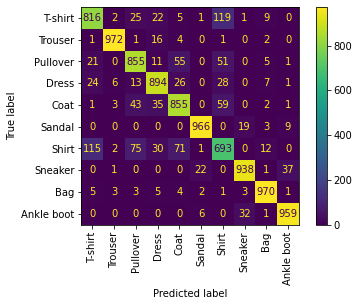

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print(f"Eval accuracy: {100 * accuracy_score(labels, predictions):.2f}%")

cm = confusion_matrix(labels, predictions)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation='vertical')

>Eval accuracy: 89.32%
![png](static/from_0_to_1_33_1.png)
As you can see, although we've got an accuracy score of ~88%, the model's
performance across the different classes isn't equal. Trousers are very well
classified, with more than 96-97% accuracy whereas shirts are harder to
classify with less than 60% accuracy, and it seems they often get confused
with T-shirts, pullovers and coats. So, some work is still required here to
improve your model for all the classes!

We can save this visualisation of the confusion matrix.

In [16]:
cm_plot.figure_.savefig("confusion_matrix.png")

# Doing more with `poptorch.Options`
This class encapsulates the options that PopTorch and PopART will use
alongside our model. Some concepts, such as "batch per iteration" are
specific to the functioning of the IPU, and within this class some
calculations are made to reduce risks of errors and make it easier for
PyTorch users to use IPUs.

The list of these options is available in the [documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/overview.html#options).
Let's introduce here 4 of these options to get an idea of what they cover.

### `deviceIterations`
Remember the training loop we have discussed previously. A device iteration
is one cycle of that loop, which runs entirely on the IPU (the device), and
which starts with a new batch of data. This option specifies the number of
batches that is prepared by the host (CPU) for the IPU. The higher this
number, the less the IPU has to interact with the CPU, for example to request
and wait for data, so that the IPU can loop faster. However, the user will
have to wait for the IPU to go over all the iterations before getting the
results back. The maximum is the total number of batches in your dataset, and
the default value is 1.

### `replicationFactor`
This is the number of replicas of a model. A replica is a copy of a same
model on multiple devices. We use replicas as an implementation of data
parallelism, where a same model is served with several batches of data at the
same time but on different devices, so that the gradients can be pooled. To
achieve the same behaviour in pure PyTorch, you'd wrap your model with `torch.
nn.DataParallel`, but with PopTorch, this is an option. Of course, each
replica requires one IPU. So, if the `replictionFactor` is two, two IPUs are
required.

### `randomSeed`
The IPU has a different, on-device pseudo-random number generator (PRNG).
This option sets the seed for the PRNG on the IPU. This is equivalent to
using `torch.seed`.

### `useIpuModel`
An IPU Model is a simulation, running on a CPU, of an actual IPU. This can be
helpful if you're working in an environment where no IPUs are available but
still need to make progress on your code. However, the IPU Model doesn't
fully support replicated graphs and its numerical results can be slightly
different from what you would get with an actual IPU. You can learn more
about the IPU Model and its limitations with our [documentation]
(https://docs.graphcore.ai/projects/poplar-user-guide/en/latest/poplar_programs.html?highlight=ipu%20model#programming-with-poplar).

## How to set the options
These options are callable, and chainable as they return the instance. One
can therefore do as follows:

In [17]:
opts = poptorch.Options().deviceIterations(20).replicationFactor(2).randomSeed(123).useIpuModel(True)


# Going further

Other tutorials will be made available in the future to explore more advanced
features and use cases for PopTorch. Make sure you've subscribed to our
newsletter to stay up to date.

In the meantime, to learn more about the IPU and the lower level Poplar
libraries and graph programming framework, you can go through our Poplar
tutorials and read our Poplar SDK overview.